In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def weight_init(experts,method=1):
    #add market cap initialization
    if method == 1:
        return np.ones(experts)

def losses(data,time,method=1):
    if method == 1: #price relative
        return -1*data.iloc[time]
    elif method==2: #absolute return (close-open)
        return 1
    elif method==3: #beta
        return 1

In [8]:
def mwu(data):
    #data = np.array(data)
    #data is a T by N matrix with each row being the returns of each expert i at time t
    T = len(data)
    N = len(data.columns)
    epsilon = np.sqrt(np.log(N)/T) # is this correct
    
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    
    #find bounds for loss
    #M = 1 #max(np.max(data.values),-1*np.min(data.values))
    w = weight_init(N)
    #iterations
    #print(T,N)
    start = 10000000
    quantities = [(w*start)/opening_prices]
    weights = [w]
    values =[start]
    transaction = []
    
    for t in range(1,T+1):
        opening_prices = opening[t-1]
        #portfolio value
        values.append(sum(opening_prices*quantities[t-1]))
        #losses
        M = max(abs(loss))
        loss = losses(data,t)/M #positive return is negative loss to increase weight
        
        #check sum of weight updates
        money_moved = sum(abs([-w[i]*epsilon*loss[i]/M]))*values[t]
        
        if values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1-epsilon*loss[i]/M)
            transaction.append(0.015*money_moved)
        weights.append(w)
        
        #starting quantities
        quantities.append((w*values[t])/opening_prices)
        
    p = w/sum(w)
    return p

In [7]:
data = pd.read_excel('lowvol_weekly.xlsx')
opening = data.iloc[:,::2]
closing = data.iloc[:,1::2]

,WMT_close,BK_close,CI_close,JPM_close,DD_close,CL_close,HIG_close,AFL_close,DOX_close,BCE_close,BRK.B_close,KO_close,HON_close,L_close,PEP_close,RSG_close,PG_close,SYY_close,WU_close
2019-11-20,118.68,48.56,198.88,129.195,65.74,66.930,61.70,54.05,68.40,47.86,216.62,53.185,176.96,50.3601,133.635,87.64,121.555,79.57,26.905
2019-11-15,118.87,48.57,196.01,129.530,67.64,66.370,62.00,54.40,68.68,48.50,219.74,52.670,181.75,50.1600,133.810,86.91,120.540,81.61,26.800
2019-11-08,119.44,49.20,188.20,130.380,71.13,66.630,61.09,54.14,67.12,47.80,221.31,52.210,181.21,51.0000,133.130,86.18,119.700,80.40,27.870
2019-11-01,117.62,47.16,179.51,127.800,69.64,66.810,57.52,53.61,65.60,47.52,215.83,53.900,176.12,49.7900,136.930,86.68,123.870,81.28,26.480
2019-10-25,119.04,46.38,171.49,126.030,66.85,68.410,56.80,53.26,65.16,46.65,211.80,53.750,171.63,51.0000,136.640,86.03,123.250,79.17,24.820
2019-10-18,119.14,45.34,166.88,120.560,65.53,68.030,59.00,52.71,66.10,48.87,208.76,54.780,165.57,50.9600,136.250,88.24,117.470,79.14,24.030
2019-10-11,120.24,44.12,152.40,116.140,65.16,70.510,58.64,52.44,66.00,48.88,208.08,53.300,163.53,50.4800,137.640,86.38,121.090,78.87,23.730
2019-10-04,118.16,42.63,150.74,114.620,68.15,72.070,59.51,52.10,66.44,48.63,208.08,54.540,163.63,49.9900,140.280,86.74,124.000,78.15,23.310
2019-09-27,118.45,44.53,149.48,117.720,70.25,73.260,60.45,51.89,65.74,48.41,207.45,54.310,168.04,51.5100,135.600,86.22,124.570,78.87,23.050
2019-09-20,116.98,46.38,161.38,118.900,71.60,70.950,60.44,51.97,65.78,48.37,208.12,53.910,168.31,50.9700,134.710,87.48,122.240,78.24,22.510


{'XOM': 0.02832, 'SBUX': 0.02887, 'AAPL': 0.02927, 'GOOG': 0.02879, 'PYPL': 0.02869, 'FB': 0.02868, 'NFLX': 0.0283, 'SQ': 0.02947, 'MSFT': 0.02843, 'IBM': 0.02836, 'MCD': 0.02853, 'AMZN': 0.0278, 'NKE': 0.02857, 'TSLA': 0.02875, 'EL': 0.02869, 'CSCO': 0.02846, 'WMT': 0.02926, 'KO': 0.02874, 'PM': 0.02861, 'PG': 0.0291, 'PEP': 0.02866, 'GS': 0.0281, 'BAC': 0.0283, 'JPM': 0.02873, 'BLK': 0.0281, 'ICE': 0.0285, 'SO': 0.02948, 'PBR': 0.02734, 'RUN': 0.02951, 'MRO': 0.02676, 'PFE': 0.02853, 'ANTM': 0.02905, 'CI': 0.02834, 'HUM': 0.02847, 'JNJ': 0.02845}


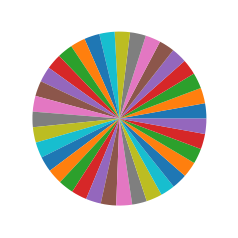

In [10]:
x=mwu(data)
out_dict = {data.columns[i]:round(x[i],5) for i in range(len(data.columns))}
plt.pie(x)
print(out_dict)